# FICO - The Explainable Machine Learning Challenge
### Kacper Siemaszko, Wojciech Kretowicz, Mateusz Polakowski


---

## Wstęp

Udzielenie kredytu bankowego wraz z biegiem czasu ulega skomplikowanym i nowoczesnym modyfikacjom. Mimo, że rezultatem dalej jest jedynie odpowiedź *tak* lub *nie*, to używane narzędzia rozwijają się praktycznie z dnia na dzień. W związku z tym coraz bardziej powszechne staje się używanie uczenia maszynowego w tym zakresie, a zwracane sugestie modeli mogą mieć spore znaczenie w finalnej decyzji wielu instytucji bankowych na świecie.

Konkurs zorganizowany między innymi przez *FICO* oraz *Google* polegał na stworzeniu dobrego, celnego, ale również jak najbardziej interpretowalnego modelu predykcyjnego. Dane, na których się opierał, dotyczyły zanonimizowanych informacji konsumentów banków, a zadanie, które zostało postawione, to trafne określenie ryzyka udzielenia kredytu danemu konsumentowi. Cześciej zadanie te nosi nazwę *scoringu* kredytowego.

Mimo, że celem konkursu było stworzenie modelu, to ponadto, jako zespół, pochyliliśmy się również nad analizą posiadanego zbioru danych. Stąd, zanim przejdziemy do omawiania stworzonych modeli oraz finalnej wersji, przyjrzymy się budowie zbioru danych oraz ciekawym informacjom, które możemy z niego wyciągnąć. 

Następnie porównamy działanie wielu popularnych algorytmów klasyfikacyjnych, aby potem przejść do docelowej wersji algorytmu. Przekonamy się, że dane pozwalają osiągnąć jedynie pewien pułap celności, którego przebić się po prostu nie da z posiadanymi informacjami. Tym samym, nie tracąc na skuteczności, pochylimy się bardziej nad interpretowalnością proponowanego przez nas rozwiązania.

---

## Exploratory data analysis - analiza zbioru danych

### Wartości specjalne

Jak wspomniane we wstępie, na rozgrzewkę zajmijmy się spojrzeniem na zbiór danych z wielu stron, aby go lepiej zrozumieć. Zawiera on aż $24$ kolumny, z czego *RiskPerformance* to zmienna celu, którą zamierzamy przewidywać. Wszystkie pozostałe $23$ kolumny to kolumny liczbowe, które kodują pewne informacje o kliencie banku. Przekonamy się później, że będzie można te cechy pogrupować w bardzo efektywny sposób. Stąd nie będziemy póki co omawiać każdej kolumny z osobna - mijałoby się to z celem raportu oraz postawionego zadania. 

Spójrzmy zatem najpierw na mały urywek tego, co jest w zbiorze. 

In [22]:
# Wczytanie potrzebnych pakietów
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, \
                            precision_score, confusion_matrix, f1_score, roc_curve

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [24,24]
plt.style.use('seaborn-whitegrid')


import category_encoders as ce
import networkx as nx

import warnings

warnings.filterwarnings('ignore')

# Przygotowanie danych i wyświetlenie próbki
df = pd.read_csv("data/heloc_dataset_v1.csv")
df.iloc[:, :6].head()

,RiskPerformance,ExternalRiskEstimate,MSinceOldestTradeOpen,MSinceMostRecentTradeOpen,AverageMInFile,NumSatisfactoryTrades
0,Bad,55,144,4,84,20
1,Bad,61,58,15,41,2
2,Bad,67,66,5,24,9
3,Bad,66,169,1,73,28
4,Bad,81,333,27,132,12


Zanim pojawią się ciekawe wykresy, to zwróćmy uwagę na same wartości. Mianowicie, istnieją 3 wartości specjalne w zbiorze:

* $-7$: *Condition not Met (e.g. No Inquiries, No Delinquencies)*,
* $-8$: *No Usable/Valid Trades or Inquiries*,
* $-9$: *No Bureau Record or No Investigation*,

z czego w przypadku $-9$ są to praktycznie pełne rekordy braków danych. Przekonajmy się, czy te wartości mają jakikolwiek wpływ na zbiór danych:

In [5]:
print("Odsetek rekordów samych -9 z rekordami zawierającymi jakiekolwiek wartości -9:",
      np.round(((df == -9).sum(axis=1) == 23).sum() / ((df == -9).sum(axis=1) >0).sum(), 2))

Odsetek rekordów samych -9 z rekordami zawierającymi jakiekolwiek wartości -9: 0.98


Aby uniknąć nadmiernego skomplikowania modelu wyrzućmy rekordy zawierające co najmniej jedną wartość $-9$. Niestety, tego samego nie można powiedzieć o wartościach $-8$ oraz $-7$ - są one bardziej powszechne w zbiorze oraz wymieszane między rekordami. Je należy w zbiorze zostawić, ze względu na możliwy wpływ wyniku scoringu:

In [6]:
df = df.loc[(df == -9).sum(axis=1)==0, :]
print("Rekordy z wartością -7:", ((df == -7).sum(axis=1) >0).sum())
print("Rekordy z wartością -8:", ((df == -8).sum(axis=1) >0).sum())

Rekordy z wartością -7: 5681
Rekordy z wartością -8: 4219


Jako potwierdzenie powyższego spójrzmy na histogramy zmiennej celu, czyli *RiskPerformance*, w zależności od zmiennych $-8$ i $-7$ w przykładowych kolumnach:

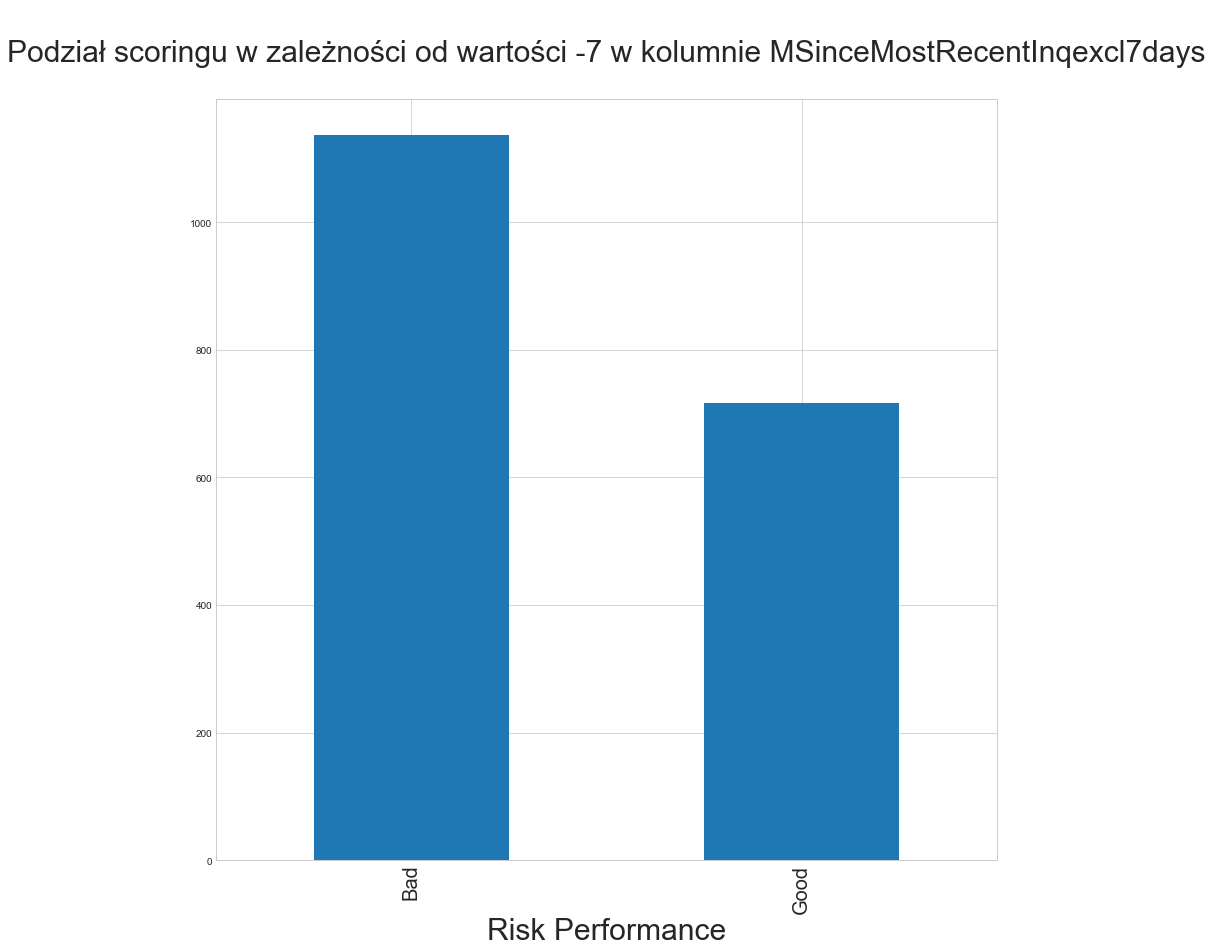

In [7]:
plt.figure(figsize=(14,14))
df.loc[(df.MSinceMostRecentInqexcl7days == -7), :].groupby(by='RiskPerformance').count()['ExternalRiskEstimate'].plot(kind='bar')
plt.xlabel("Risk Performance", fontsize=30)
plt.xticks(fontsize=20)
plt.title("\nPodział scoringu w zależności od wartości -7 w kolumnie MSinceMostRecentInqexcl7days\n", 
         fontsize=30)
plt.show()

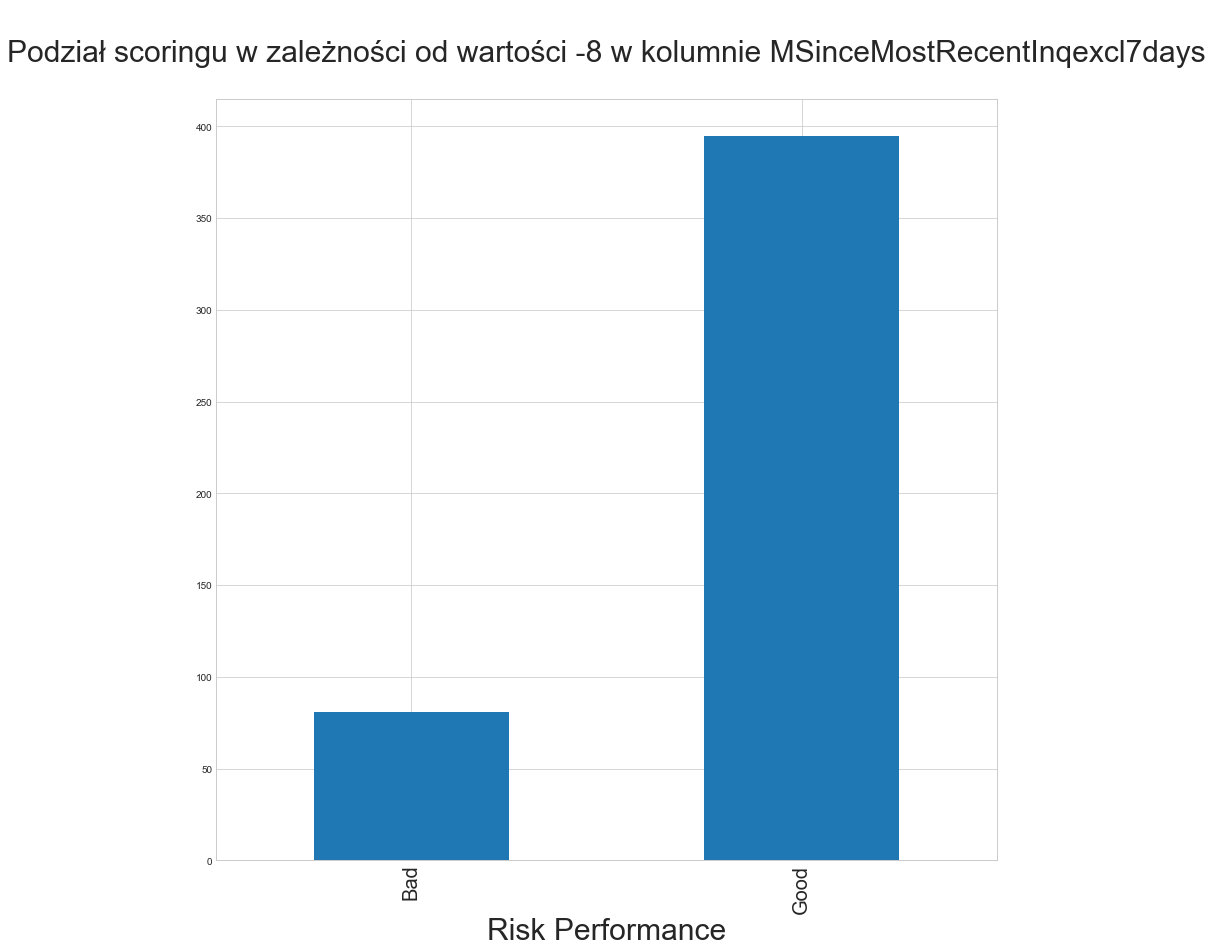

In [8]:
plt.figure(figsize=(14,14))
df.loc[(df.MSinceMostRecentInqexcl7days == -8), :].groupby(by='RiskPerformance').count()['ExternalRiskEstimate'].plot(kind='bar')
plt.xlabel("Risk Performance", fontsize=30)
plt.xticks(fontsize=20)
plt.title("\nPodział scoringu w zależności od wartości -8 w kolumnie MSinceMostRecentInqexcl7days\n", 
         fontsize=30)
plt.show()

### Korelacje między zmiennymi

Pierwszym pytaniem, jakie powinniśmy sobie zadać, to czy posiadane cechy są jakkolwiek ze sobą skorelowane. Mimo zapowiedzi, że da się je połączyć w kategorie, przekonajmy się, że faktycznie istnieją cechy między sobą zależne. Takim przykładem są *NumSatisfactoryTrades* oraz *NumTotalTrades*, które traktują o liczbie dokonanych pomyślnie i dokonanych ogółem transakcji. Można się spodziewać, że dla poszczególnego klienta nie będą one od siebie odbiegać - rzadko kiedy zdarza nam się w ogóle żeby te wartości się od siebie różniły.

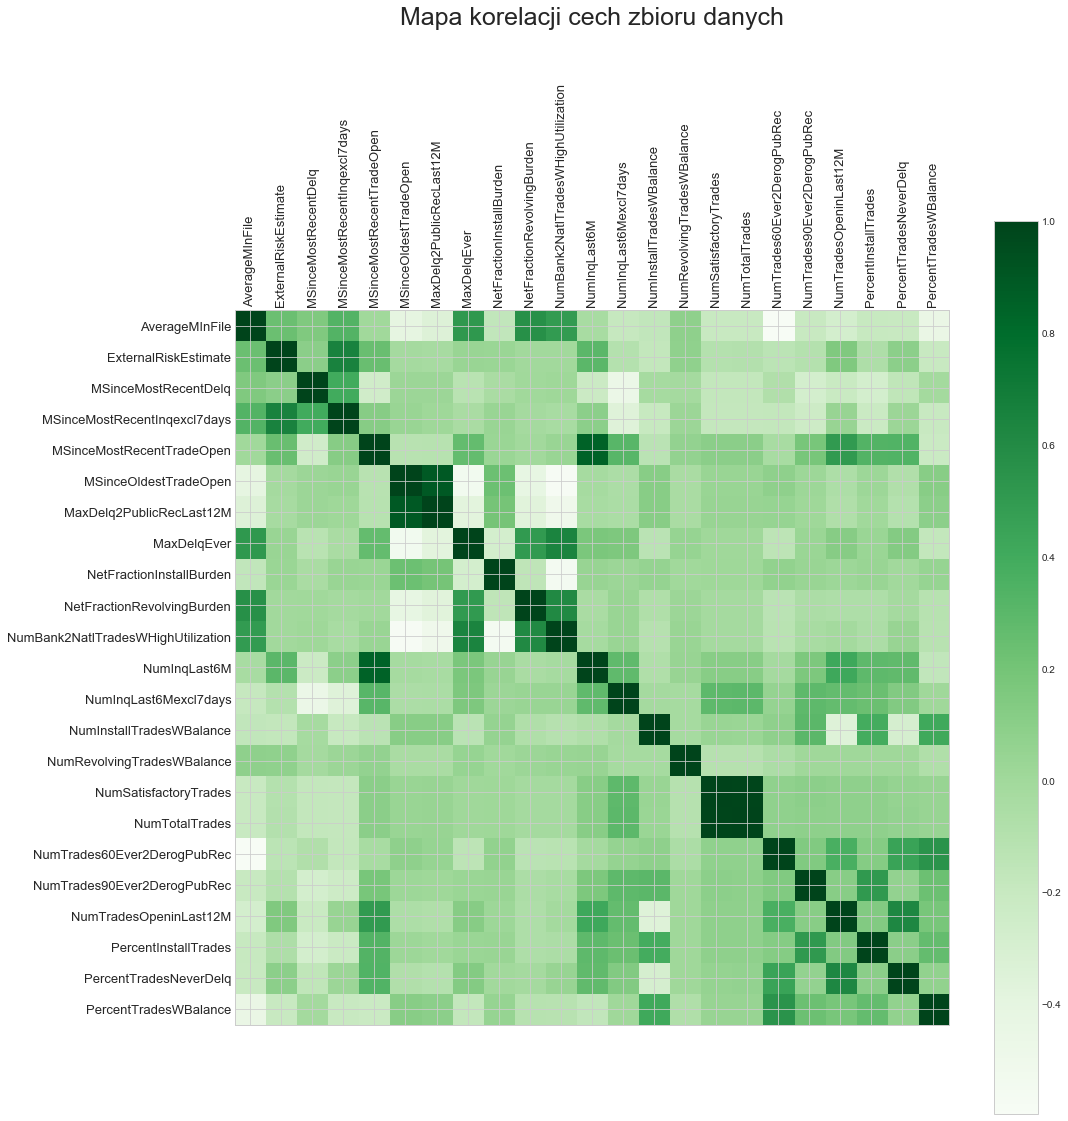

In [9]:
plt.matshow(df.iloc[:, 1:24].corr(), cmap=plt.cm.Greens)
plt.xticks(np.arange(0, 23), df.columns.sort_values(), rotation=90, size=13)
plt.yticks(np.arange(0, 23), df.columns.sort_values(), size=13)
plt.colorbar()
plt.title("Mapa korelacji cech zbioru danych", pad=250, size=25)
plt.show()

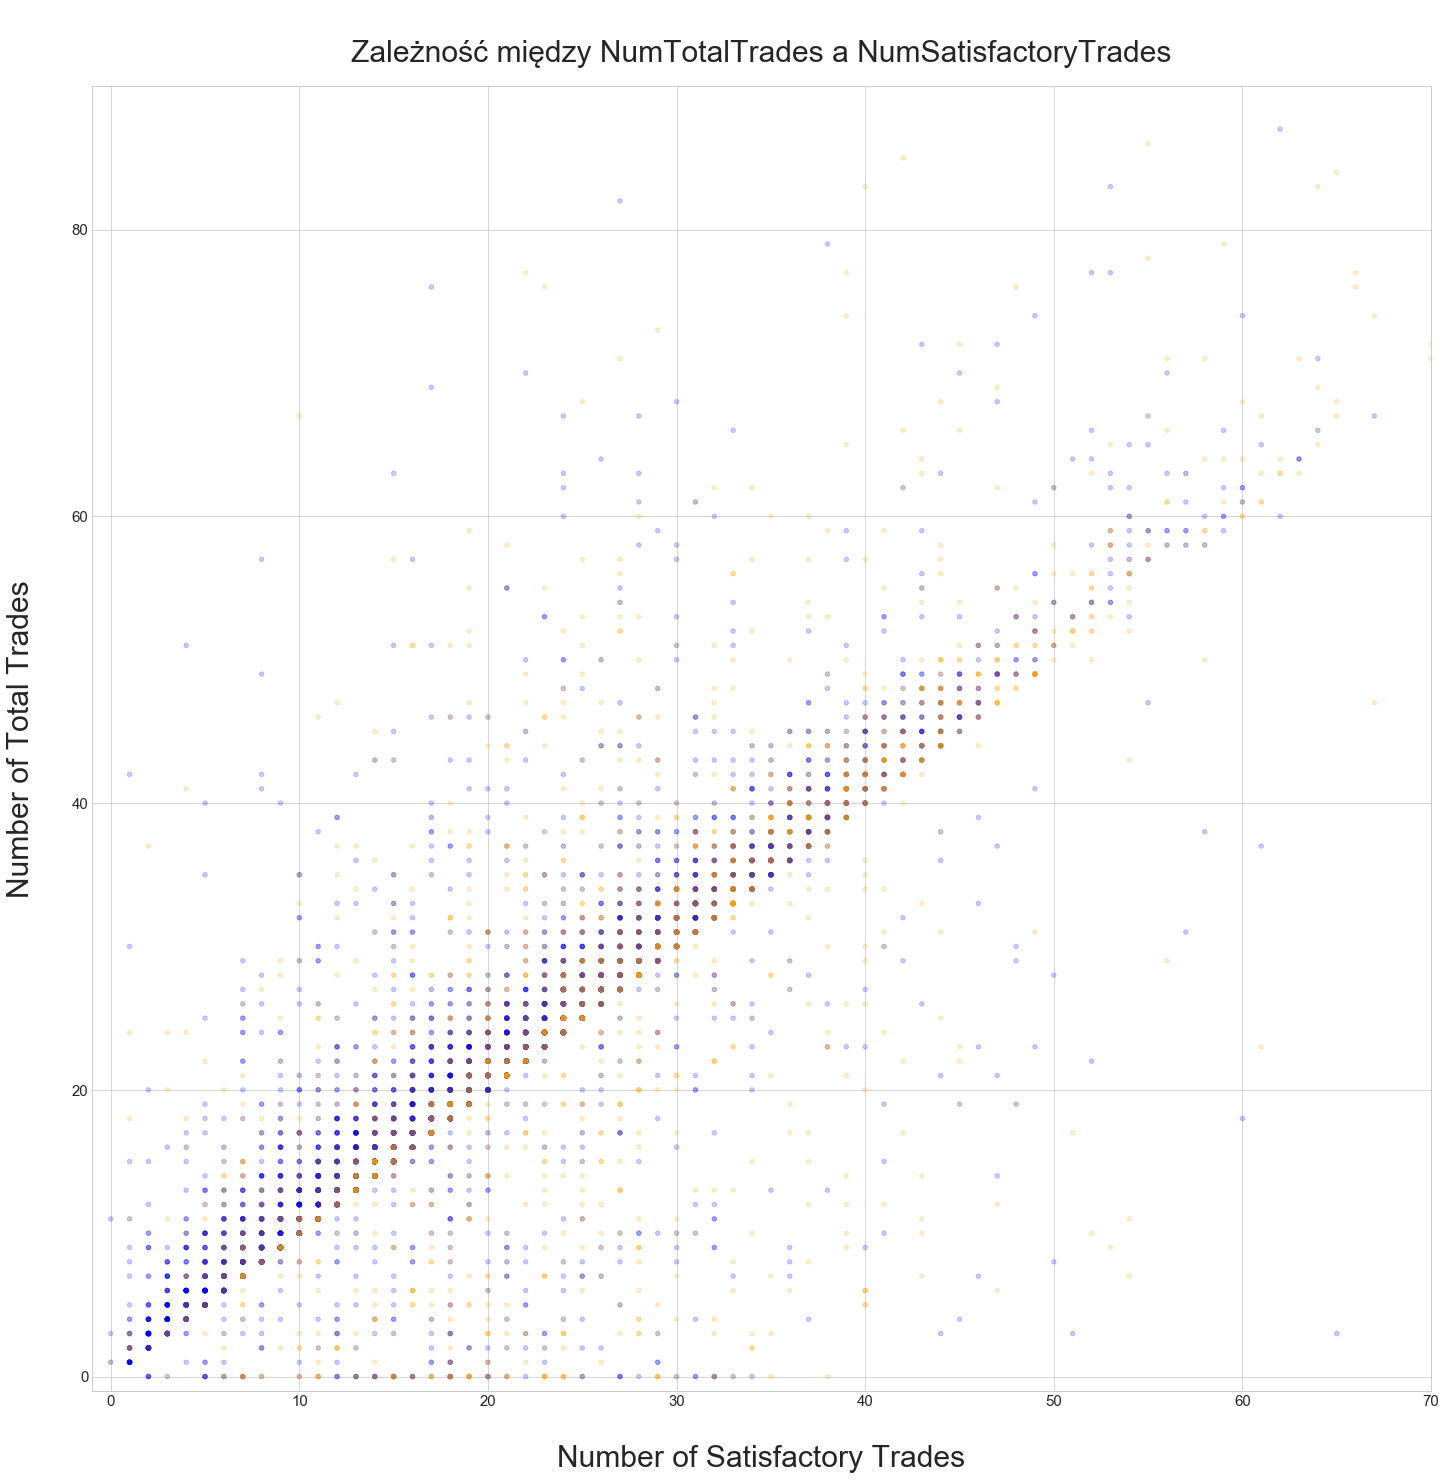

In [10]:
c = (df.RiskPerformance=='Good').apply(lambda x : 'orange' if x==1 else 'blue')
df.plot(kind='scatter', x='NumSatisfactoryTrades', y='NumTotalTrades', c=c, alpha=0.2)
plt.xticks(fontsize=15); plt.yticks(fontsize=15)
plt.xlabel("\nNumber of Satisfactory Trades", fontsize=30); plt.ylabel("Number of Total Trades\n", fontsize=30)
plt.xlim(-1, 70); plt.ylim(-1, 90)
plt.title("\nZależność między NumTotalTrades a NumSatisfactoryTrades", size=30, pad=25)
plt.show()

### Rozkłady wybranych zmiennych

Idąc dalej, sprawdźmy jak wyglądają rozkłady wartości z wybranych kolumn. Wiele cech zbioru nie nadaje się do pokazania, ponieważ w znaczącej większości wykresy te się pokrywają niezależnie od wynikowej wartości kolumny *RiskPerformance*. Mimo tego, można spojrzeć na kilka z pozostałych:

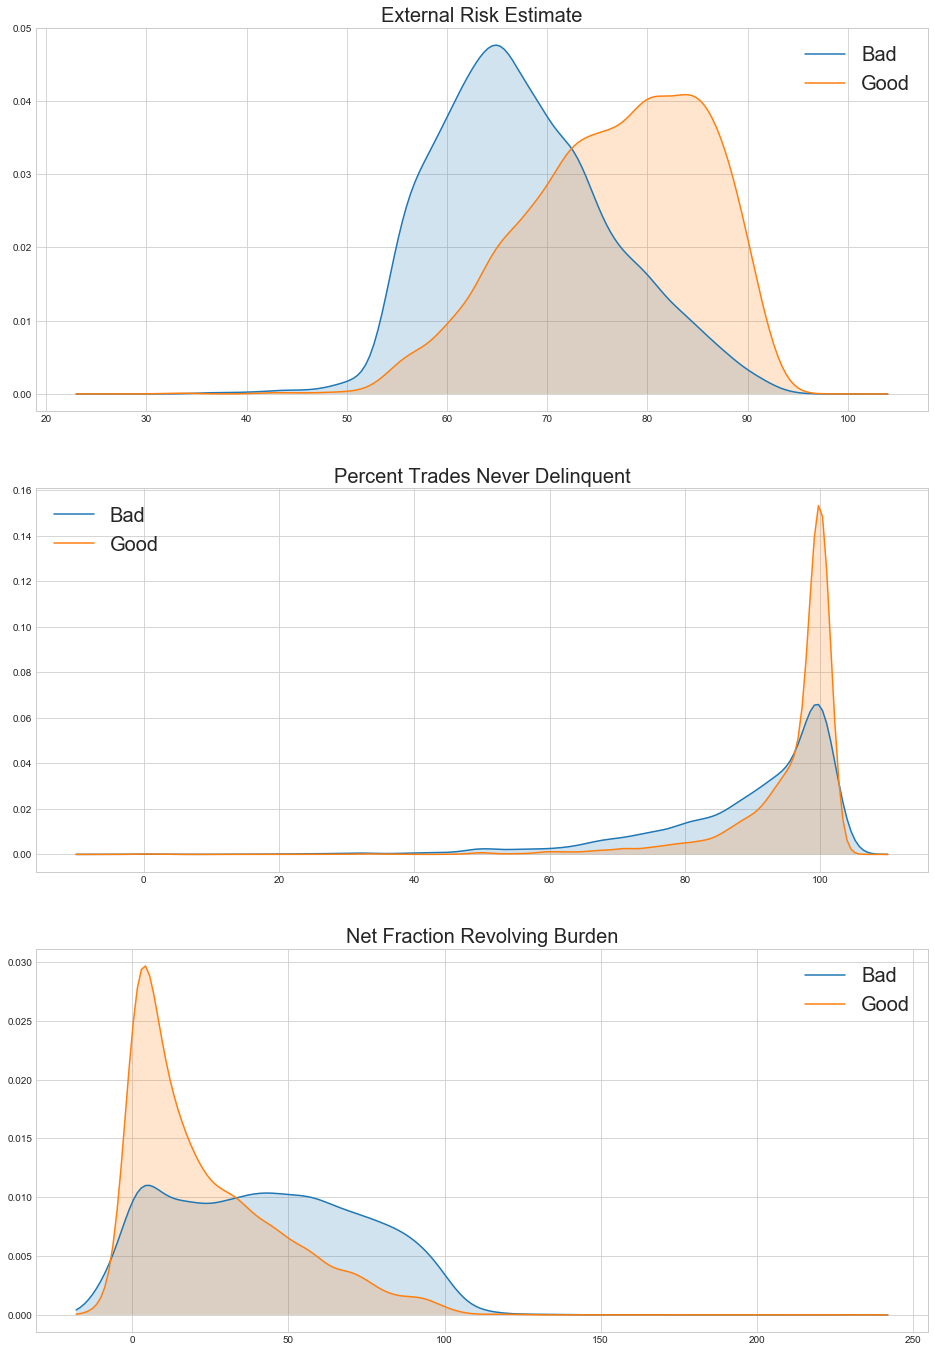

In [11]:
columns_to_show = ["ExternalRiskEstimate", "PercentTradesNeverDelq", "NetFractionRevolvingBurden"]
columns_to_show_titles = ["External Risk Estimate", "Percent Trades Never Delinquent", "Net Fraction Revolving Burden"]

fig = plt.figure(figsize=(16, 24))
axes = fig.subplots(nrows=3, ncols=1)
for i, column in enumerate(columns_to_show):
    bad, good = df.loc[df.RiskPerformance=="Bad", column].astype('float'), df.loc[df.RiskPerformance=="Good", column].astype('float')
    bad_density, good_density = stats.kde.gaussian_kde(bad), stats.kde.gaussian_kde(good)
    x = np.linspace(min(np.min(good), np.min(bad))-10, max(np.max(good), np.max(bad))+10, 200)
    axes[i].plot(x, bad_density(x), label="Bad")
    axes[i].plot(x, good_density(x), label="Good")
    axes[i].fill_between(x, bad_density(x), alpha=0.2)
    axes[i].fill_between(x, good_density(x), alpha=0.2)
    axes[i].legend(fontsize=20)
    axes[i].set_title(columns_to_show_titles[i], fontsize=20)
plt.show()

### Ocena istotności cech przy użyciu algorytmu lasu losowego

Jak w tytule podrozdziału - skorzystamy z powszechnej metody oceny istotności danych cech korzystając z trudno interpretowalnego lecz skutecznego modelu - lasu losowego. Po przeliczeniu modelu mamy dostęp do *wag* poszczególnych cech. Ponieważ wstępnie ma on zadowalającą skuteczność możemy pozwolić sobie na taki ruch:

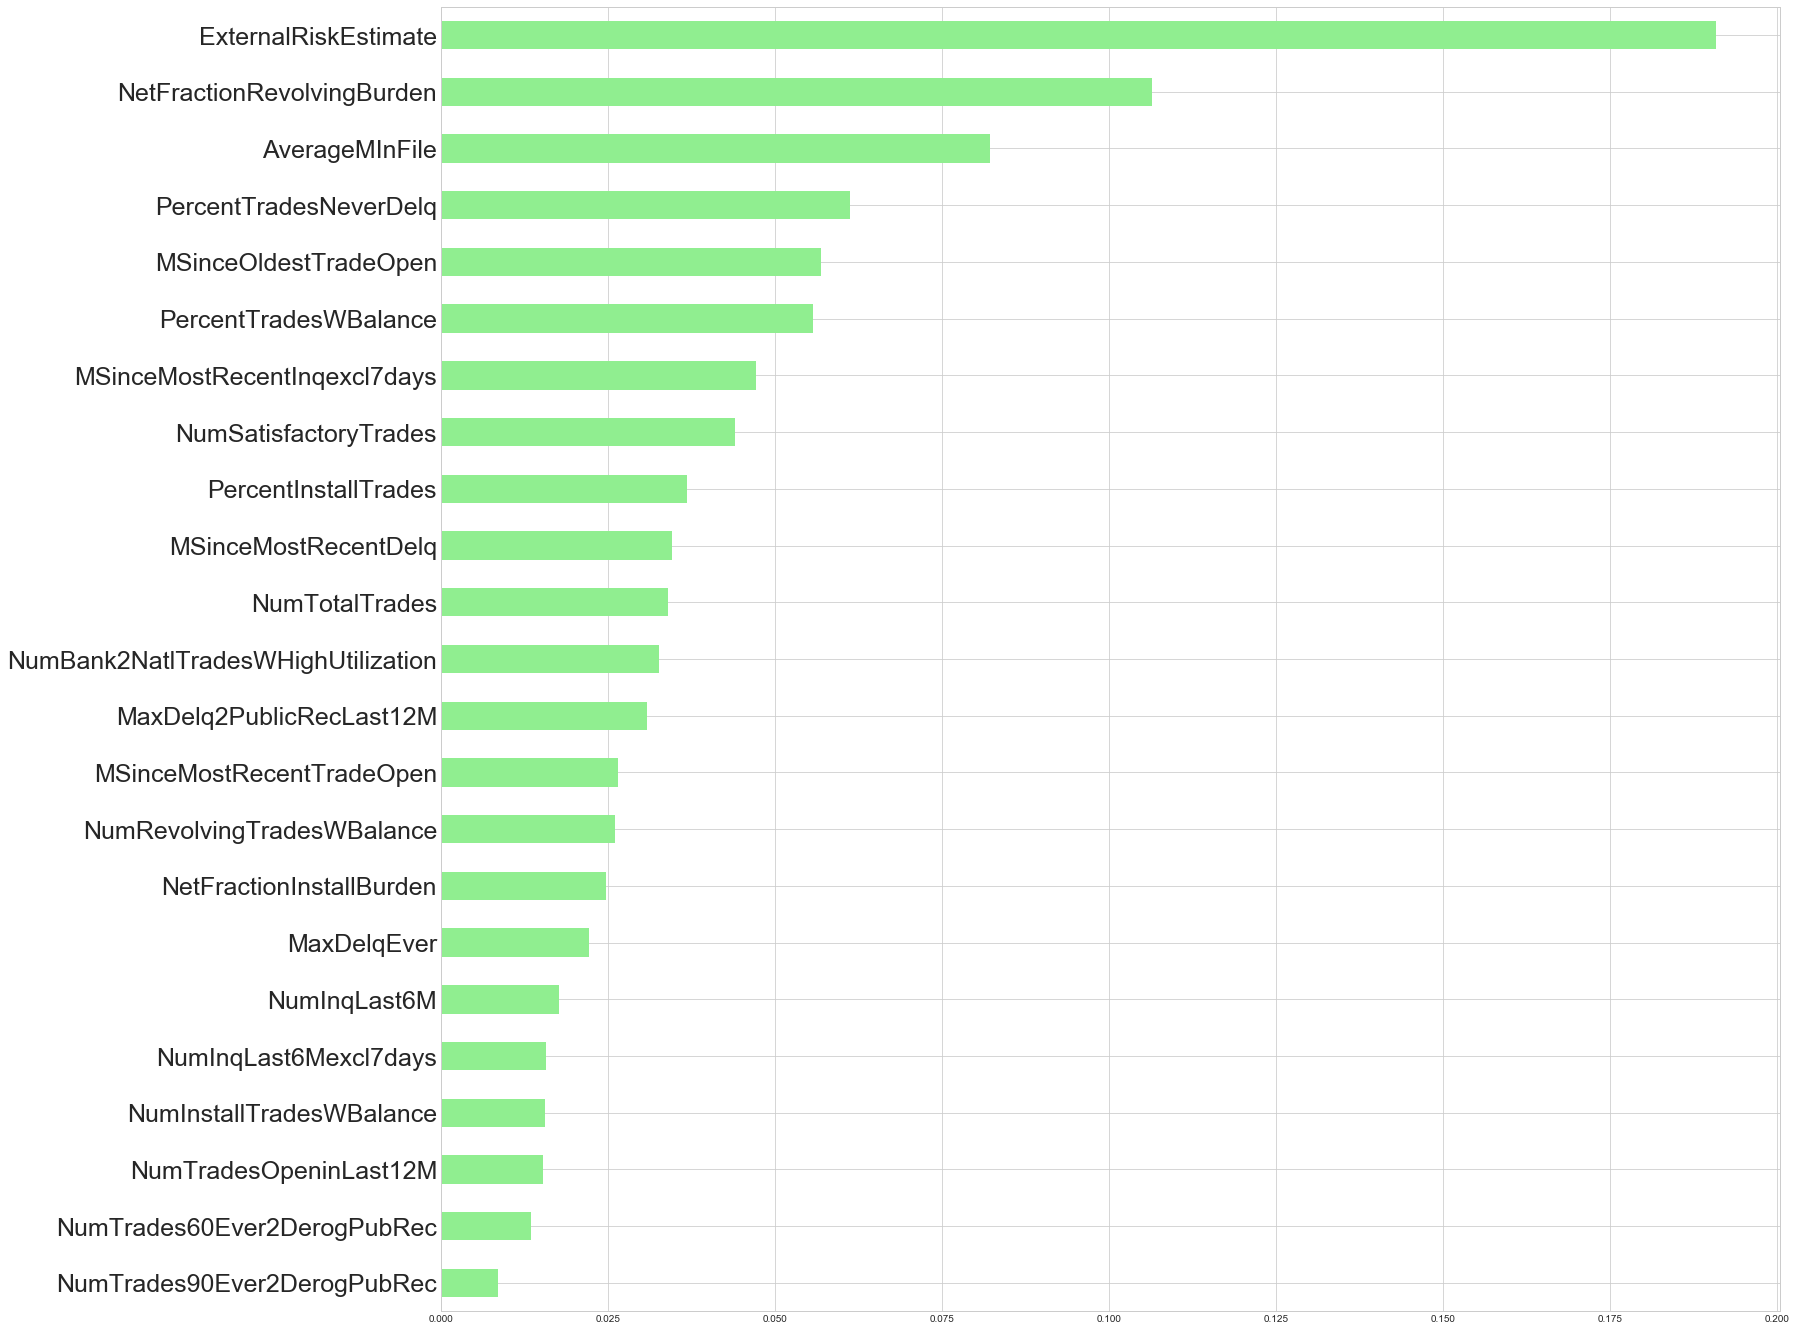

In [12]:
X, y = df.drop('RiskPerformance', axis=1), pd.Categorical(df.RiskPerformance, categories=["Bad", "Good"]).codes
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.15)

classifier = RandomForestClassifier(n_estimators = 2000, max_depth=10, random_state=42)
classifier.fit(X_train, y_train)

importances = pd.Series(dict(zip(X.columns,classifier.feature_importances_)))
importances.sort_values().plot(kind='barh', color='lightgreen')
plt.yticks(fontsize=25)
plt.show()

Jak widać, wagi poszczególnych cech różnią się zdecydowanie od siebie. Nie da ukryć sie, że cecha *ExternalRiskEstimate* jest najbardziej istotna przy przewidywaniu *scoringu*. Jest to efekt wielu algorytmów wewnętrznych w bankach, które na podstawie posiadanych informacji flagują konsumenta odpowiednią wartością, która powinna być mocną sugestią dla udzielającego kredytu.

Poza tym kolejne cechy odwołują się do informacji takich jak przebieg transakcji na koncie klienta czy dane uzyskane od innych banków dotyczące klienta. Później okaże się, że pogrupowane cechy również da się sklasyfikować pod względem *ważności*. Póki co, istnotnymi cechami do zapamiętania są omówiona *ExternalRiskEstimate*, liczba transakcji oraz informacje od innych banków.

### Wizualizacja zbioru przy użyciu algorytmu TSNE

In [16]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import seaborn as sns

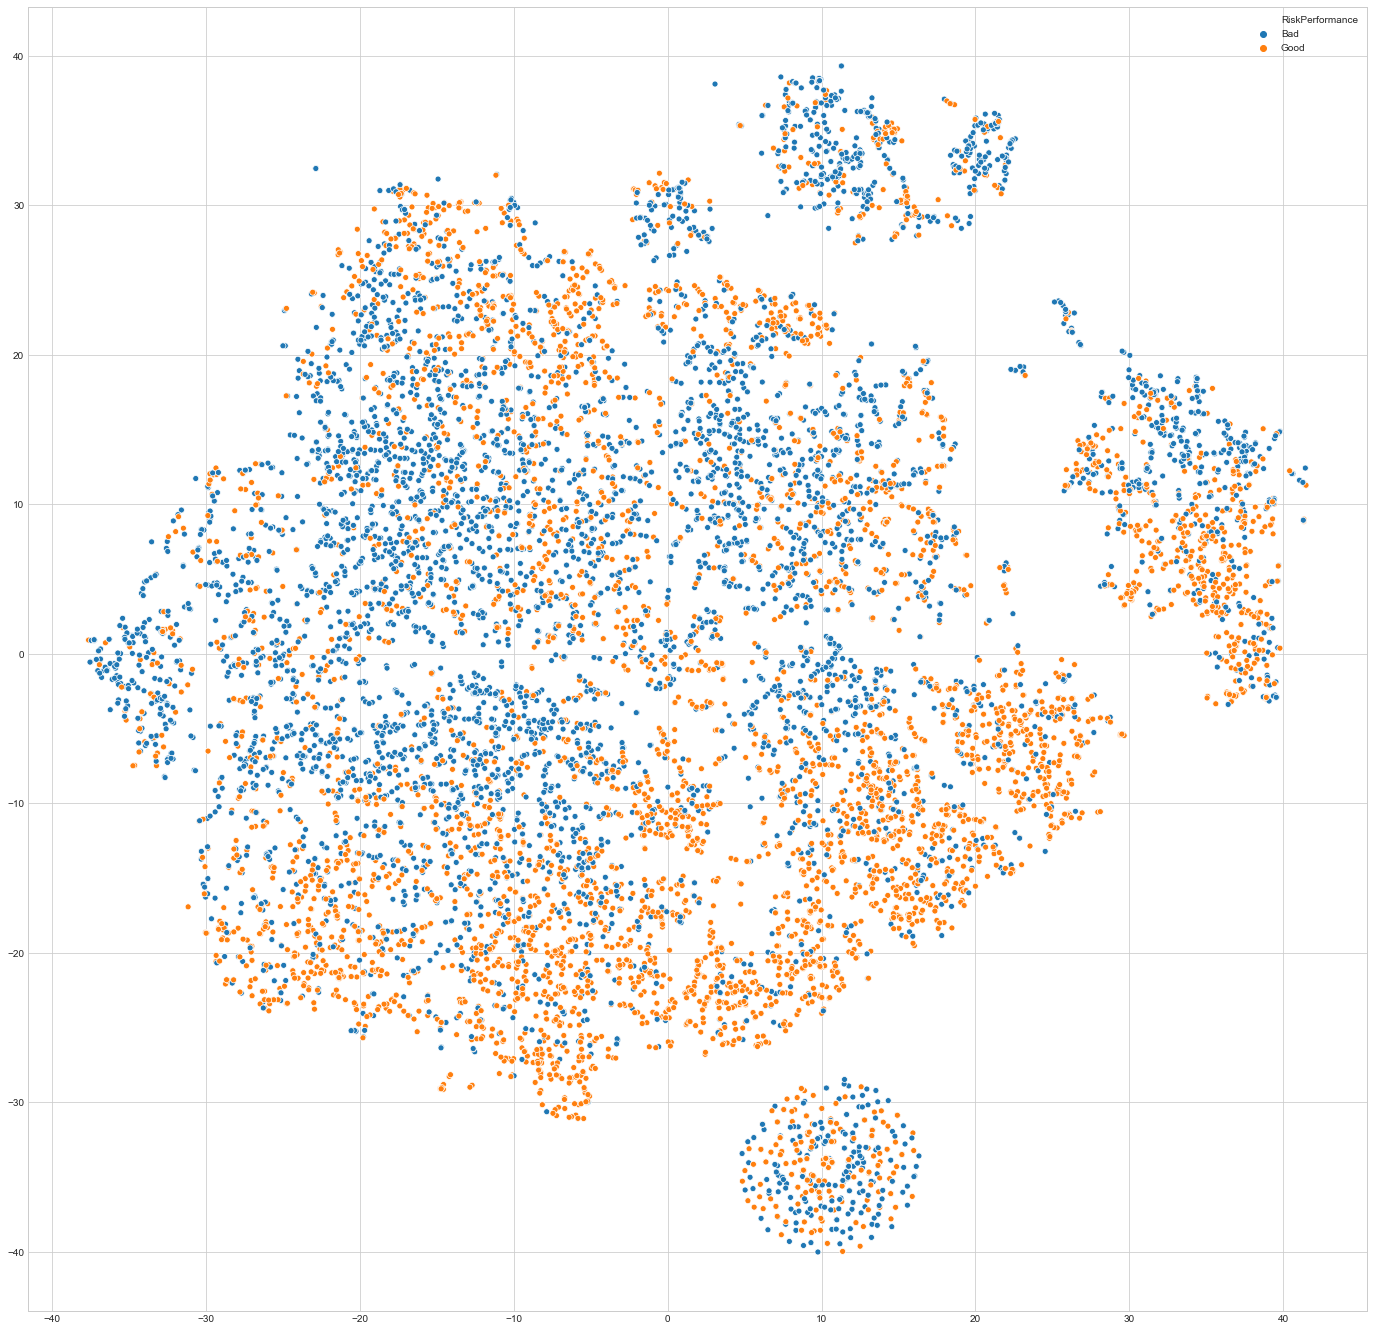

In [25]:
X, y = df.drop('RiskPerformance', axis=1), df.RiskPerformance
stdsc = StandardScaler()
X = stdsc.fit_transform(X)
tsne = TSNE(n_jobs=10)
tsne.fit(X)

sns.scatterplot(tsne.embedding_[:,0],tsne.embedding_[:,1],hue=y)
plt.show()

Użycie algorytmu TSNE sugeruje, że klasy nie są dobrze separowalne, a przynajmniej nie grupują się w naturalne klastry. Możemy też zauważyć małe zgrupowania punktów, które odzwierciedlają braki w danych. Ciekawym jest też rodzielenie głównego klastra na cztery mniejsze - ciężko jest określić z czego ono wynika.

---

## Testy wielu modeli

In [60]:
def make_classifier(X_train, y_train, classifier_class=RandomForestClassifier, params={}):
    """
        Creates classifier with given params
        returns: classifier
    """
    classifier = classifier_class(**params)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifiers(X_test, y_test, classifiers):
    """
        Evaluates given classifiers
        returns: pandas.DataFrame containing calculated model' quality metrics
    """
    scores_df = pd.DataFrame()
    for classifier_name, classifier in classifiers.items():
        y_pred = classifier.predict(X_test)
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        scores = {
            "accuracy": accuracy_score(y_test, y_pred),
            "auc": roc_auc_score(y_test, y_pred_proba),
            "precision": precision_score(y_test, y_pred),
            "recall": recall_score(y_test, y_pred),
            "f1": f1_score(y_test, y_pred)
        }
        scores_df_row = pd.DataFrame(scores, index=[classifier_name])
        scores_df = pd.concat([scores_df, scores_df_row])
    return scores_df

def plot_roc_curve(X_test, y_test, classifiers):
    """
        Plots ROC curve
    """
    plt.plot([0,1],[0,1], c='k')
    for classifier_name, classifier in classifiers.items():
        y_pred_proba = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=classifier_name)
    plt.xlabel('fpr',fontsize=24)
    plt.ylabel('tpr',fontsize=24)
    plt.title('ROC curve for trained classifiers', fontsize=36)
    plt.legend(loc=4, fontsize='xx-large')
    plt.show()
    
def highlight_max(s):
    '''
        Highlights the maximum in a Series lime
    '''
    is_max = s == s.max()
    return ['background-color: lime' if v else '' for v in is_max]

In [57]:
X, y =  df.drop(["RiskPerformance"], axis=1), pd.Categorical(df.RiskPerformance, categories=["Bad", "Good"]).codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
classifiers = { }

# Regresja logistyczna + regularyzacja
classifiers['LogisticRegression'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                                   ('log_reg', LogisticRegression())]})
# K-najblizszych sasiadow
classifiers['KNearestNeighbors'] = make_classifier(X_train, y_train, classifier_class=KNeighborsClassifier, params={'n_neighbors': 7})

# Lasy losowe
classifiers['RandomForest'] = make_classifier(X_train, y_train, classifier_class=RandomForestClassifier, params={'n_estimators':25})

# Gradient boosting
classifiers['GradientBoosting'] = make_classifier(X_train, y_train, classifier_class=GradientBoostingClassifier)

# RBF SVC
classifiers['RBFSVC'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                    ('svc', SVC(probability=True))]})

# Linear SVC
classifiers['LinearSVC'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                    ('svc', SVC(kernel='linear', probability=True))]})

# Ada boosting na drzewach decyzyjnych
classifiers['AdaBoostingOnTrees'] = make_classifier(X_train, y_train, classifier_class=AdaBoostClassifier)

# Ada boosting na regresji logistycznej
classifiers['AdaBoostingOnLogReg'] = make_classifier(X_train, y_train, classifier_class=Pipeline, params={'steps': [('scaler', StandardScaler()),
                                                                                                                   ('ada_boost', AdaBoostClassifier(base_estimator=LogisticRegression()))]})

# Gaussian process
classifiers['GaussianProcess'] = make_classifier(X_train, y_train, classifier_class=GaussianProcessClassifier)

# Naive Bayes
classifiers['NaiveBayes'] = make_classifier(X_train, y_train, classifier_class=GaussianNB)

evaluation = evaluate_classifiers(X_test, y_test, classifiers)

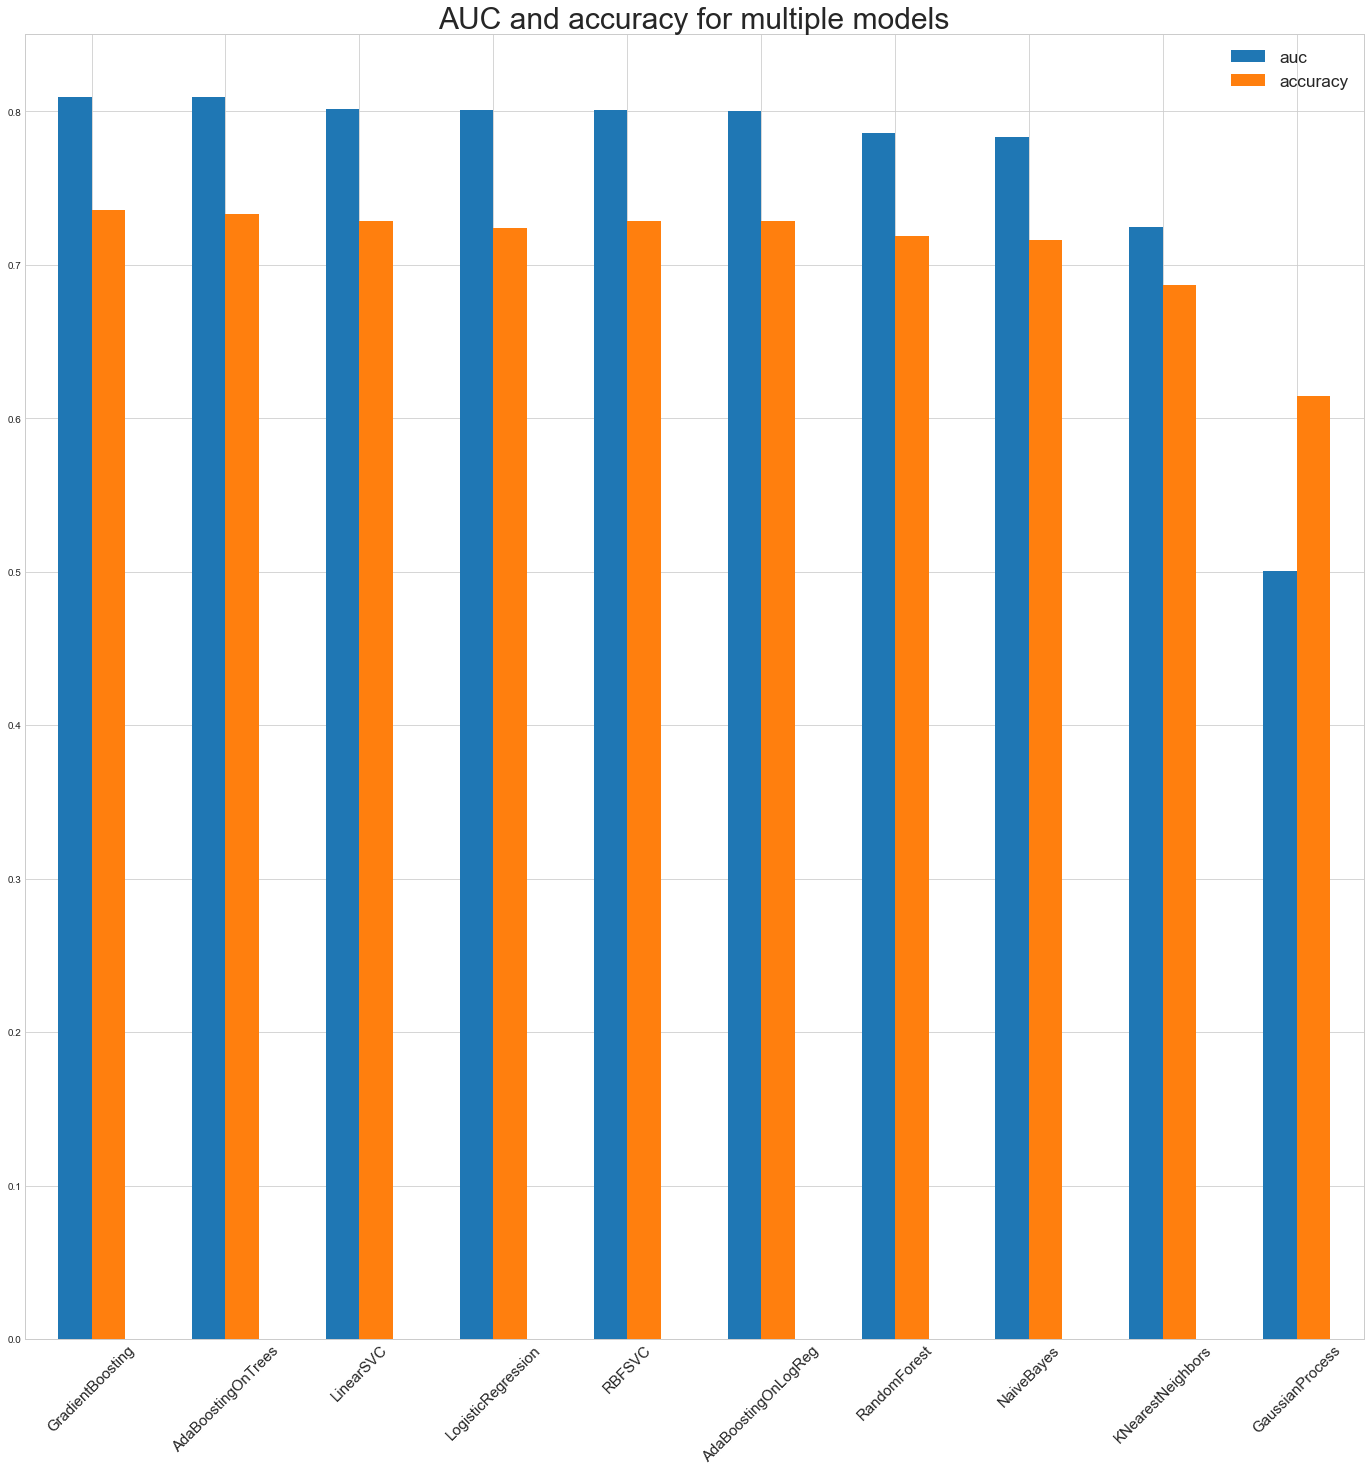

In [72]:
evaluation.loc[:,['auc','accuracy']].sort_values(ascending=False, by='auc').plot(kind='bar')
plt.xticks(size=15, rotation=45)
plt.legend(fontsize='xx-large')
plt.title('AUC and accuracy for multiple models', size = 30)
plt.show()

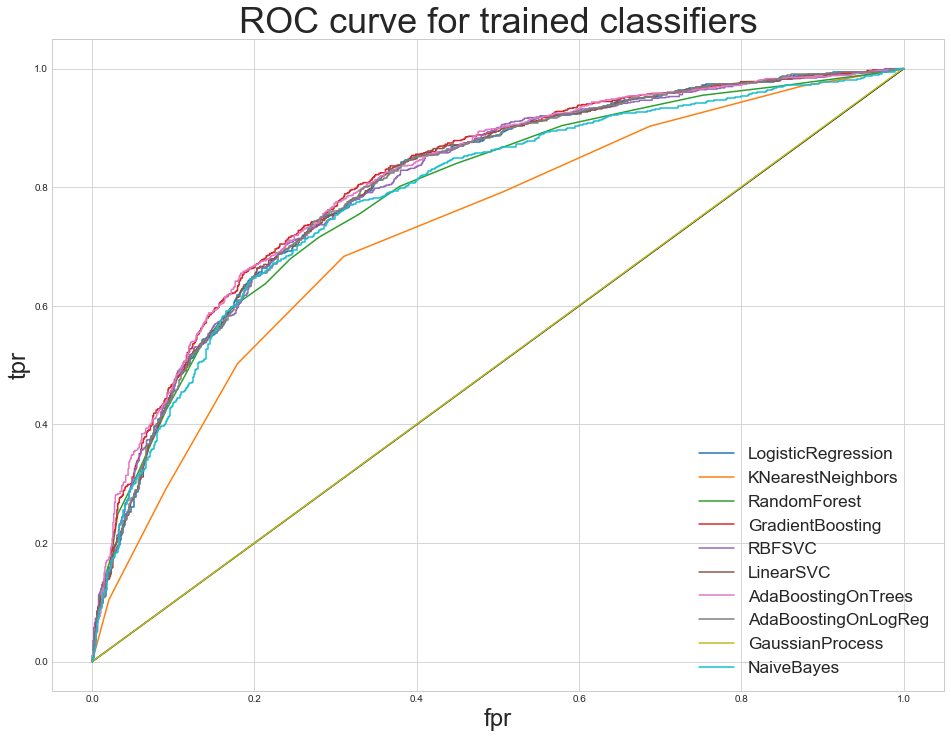

In [59]:
plt.figure(figsize=(16,12))
plot_roc_curve(X_test, y_test, classifiers)

---

## Finalny model

Jak wspomnieliśmy na początku, wszystkie cechy w wejściowym zbiorze danych da się przypisać do jednej z $10$ kategorii. Mianowicie:

* ***ExternalRiskEstimate*** - skonsolidowana wersja markerów ryzyka na linii udzielenia kredytu konsumentowi (wartość od 0 do 100, jeśli 100 - najwyższa (najlepsza) ocena zdolności kredytowej, 0 - beznadziejna)
    * *ExternalRiskEstimate*
* ***TradeOpenTime*** - rozłożenie transakcji konsumenta w czasie
    * *MSinceOldestTradeOpen*
    * *MSinceMostRecentTradeOpen*
    * *AverageMInFile*
* ***NumSatisfactoryTrades*** - liczba udanych transakcji
    * *NumSatisfactoryTrades*
* ***TradeFrequency*** - częstość, frekwencja transakcji
    * *NumTrades60Ever2DerogPubRec*
    * *NumTrades90Ever2DerogPubRec*
    * *NumTotalTrades*
    * *NumTradesOpenLast12M*
* ***Delinquency*** - przekroczenia czasowe konsumenta w transakcjach (opłatach za nie)
    * *PercentTradesNeverDelq*
    * *MSinceMostRecentDelq*
    * *MaxDelq2PublicRecLast12M*
    * *MaxDelqEver*
* ***Installment*** - informacje dotyczące rat w transakcjach konsumenta
    * *PercentInstallTrades*
    * *NetFractionInstallBurden*
    * *NumInstallTradesWBalance*
* ***Inquiry*** - kwerendy banków dotyczące szczegółów konta konsumenta w innym banku (sprawdzenie historii konta, innych kredytów itp.)
    * *MSinceMostRecentInqexcl7days*
    * *NumInqLast6M*
    * *NumInqLast6Mexcl7days*
* ***RevolvingBalance*** - dane dotyczące kredytów odnawialnych
    * *NetFractionRevolvingBurden*
    * *NumRevolvingTradesWBalance*
* ***Utilization*** - liczba kredytów wykorzystywanych przez konsumenta (*Credit utilization ratio*)
    * *NumBank2NatlTradesWHighUtilization*
* ***TradeWBalance*** - procent transakcji z saldem
    * *TradeWBalance*
    
Jest to podstawa do naszego ostatecznego modelu, w którym oprócz celności postawiliśmy na intepretowalność. Nie da się ukryć, że łatwiej patrzeć na pewne cechy konsumenta ze względu na grupę, do której należy, niż osobno. Tym samym modelowi również łatwiej te cechy analizować zbiorczo.

In [53]:
def get_intervals_for_variable(series, n=10, missing_values_indicators = [-9,-8,-7]):
    series_copy = series.copy()
    binary_dictionary = {}
    ticks = sorted(missing_values_indicators)
    ticks.append(0)
    for i in range(1, n):
        ticks.append(int(series.loc[np.logical_not(series.isin(missing_values_indicators))].quantile(i/n)))
    ticks=np.unique(ticks)
    intervals = [pd.Interval(ticks[i], ticks[i+1],closed='left') for i in range(len(ticks)-1)]
    intervals.append(pd.Interval(ticks[-1],np.inf,closed='left'))
    return pd.IntervalIndex(intervals)

def transform_input_for_submodel(X, variables, variables_intervals):
    converted_series_list = []
    for variable in variables:
        series = X.loc[:,variable].reset_index(drop=True)
        converted_series = pd.get_dummies(pd.cut(series,variables_intervals[variable]))
        converted_series.columns = pd.Series(converted_series.columns).apply(lambda x : f"{variable} - {x}")
        converted_series_list.append(converted_series)
    return pd.concat(converted_series_list, axis=1, ignore_index=True)

def create_submodel(X, y, variables, variables_intervals):
    transformed_X = transform_input_for_submodel(X, variables, variables_intervals)
    model = LogisticRegression(C=0.5)
    model.fit(transformed_X,y)
    return model

def submodels_predict(X, submodels, submodel_dictionary, variables_intervals):
    return { group: submodels[group].predict_proba(transform_input_for_submodel(X, variables, variables_intervals))[:,1] for group, variables in submodel_dictionary.items()}

submodel_dictionary = {
    "ExternalRiskEstimate": ["ExternalRiskEstimate"],
    "TradeOpenTime": ["MSinceOldestTradeOpen","MSinceMostRecentTradeOpen","AverageMInFile"],
    "NumSatisfactoryTrades": ["NumSatisfactoryTrades"],
    "TradeFrequency":["NumTrades60Ever2DerogPubRec","NumTrades90Ever2DerogPubRec","NumTotalTrades","NumTradesOpeninLast12M"],
    "Delinquency":["PercentTradesNeverDelq","MSinceMostRecentDelq","MaxDelq2PublicRecLast12M","MaxDelqEver"],
    "Installment":["PercentInstallTrades","NetFractionInstallBurden","NumInstallTradesWBalance"],
    "Inquiry":["MSinceMostRecentInqexcl7days","NumInqLast6M","NumInqLast6Mexcl7days"],
    "RevolvingBalance":["NetFractionRevolvingBurden","NumRevolvingTradesWBalance"],
    "Utilization":["NumBank2NatlTradesWHighUtilization"],
    "TradeWBalance":["PercentTradesWBalance"]
}

X, y =  df.drop(["RiskPerformance"], axis=1), pd.Categorical(df.RiskPerformance, categories=["Bad", "Good"]).codes
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=34, test_size=0.2)
variables_intervals = { variable: get_intervals_for_variable(X_train.loc[:,variable]) for variable in X_train.columns}
{group: create_submodel(X_train, y_train, variables, variables_intervals) for group, variables in submodel_dictionary.items()}
submodels = {group: create_submodel(X_train, y_train, variables, variables_intervals) for group, variables in submodel_dictionary.items()}
model = LogisticRegression(C=0.5, fit_intercept=True)
model.fit(pd.DataFrame(submodels_predict(X_train, submodels, submodel_dictionary, variables_intervals)), y_train)
print(f'training set auc: {np.round(roc_auc_score(y_train,model.predict_proba(pd.DataFrame(submodels_predict(X_train, submodels, submodel_dictionary, variables_intervals)))[:,1]),3)}')
print(f'training set acc: {np.round(accuracy_score(y_train,model.predict(pd.DataFrame(submodels_predict(X_train, submodels, submodel_dictionary, variables_intervals)))),3)}')
print(f'test set auc:     {np.round(roc_auc_score(y_test,model.predict_proba(pd.DataFrame(submodels_predict(X_test, submodels, submodel_dictionary, variables_intervals)))[:,1]),3)}')
print(f'test set acc:     {np.round(accuracy_score(y_test,model.predict(pd.DataFrame(submodels_predict(X_test, submodels, submodel_dictionary, variables_intervals)))),3)}')

training set auc: 0.811
training set acc: 0.738
test set auc:     0.812
test set acc:     0.745


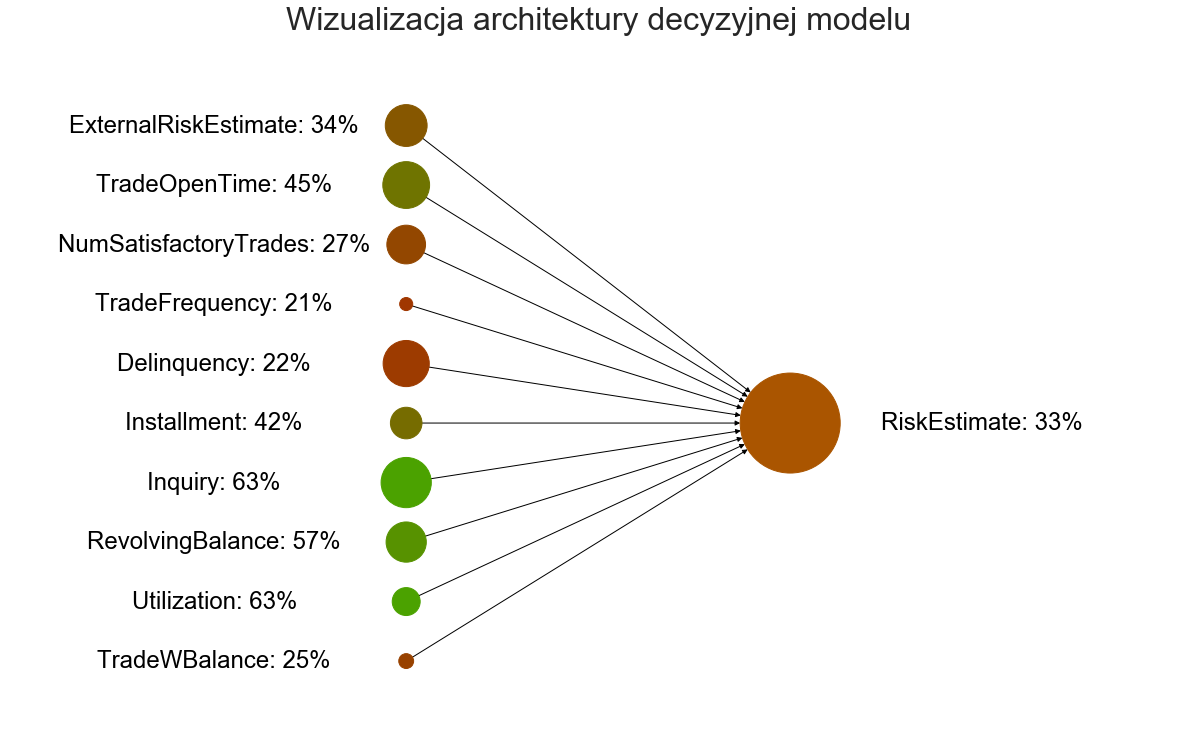

In [56]:
subpredictions = pd.DataFrame(submodels_predict(X_test.iloc[[i]], submodels, submodel_dictionary, variables_intervals))
prediction = float(model.predict_proba(subpredictions)[:,1])
G = nx.DiGraph()
target_label = f'RiskEstimate: {int(prediction*100)}%'
G.add_node(target_label)
left_labels = []
color_map = [(1-prediction,prediction,0)]
size_map= [10000]
for k, submodel in enumerate(submodel_dictionary.keys()):
    subprediction = float(subpredictions.loc[:,submodel])
    node_label = f'{submodel}: {int(subprediction*100)}%'
    left_labels.append(node_label)
    G.add_node(node_label)
    G.add_edge(node_label, target_label)
    color_map.append(((1-subprediction)*0.8,subprediction,0))
    size_map.append(model.coef_[0][k]*1000)

pos = {node: np.array([0, -i + 5]) for i, node in enumerate(left_labels)}
pos[target_label] = np.array([0.5,0])

label_pos = pos.copy()
for label, position in label_pos.items():
    label_pos[label] = np.array([label_pos[label][0]-0.25,label_pos[label][1]])
label_pos[target_label] = np.array([0.75,-0])

plt.figure(figsize=(16,9))
nx.draw(G,pos=pos,node_color=color_map,node_size=size_map)
nx.draw_networkx_labels(G,label_pos,font_size=24)
plt.xlim((-0.5,1))
plt.title('Wizualizacja architektury decyzyjnej modelu\n', size = 32)
plt.show()

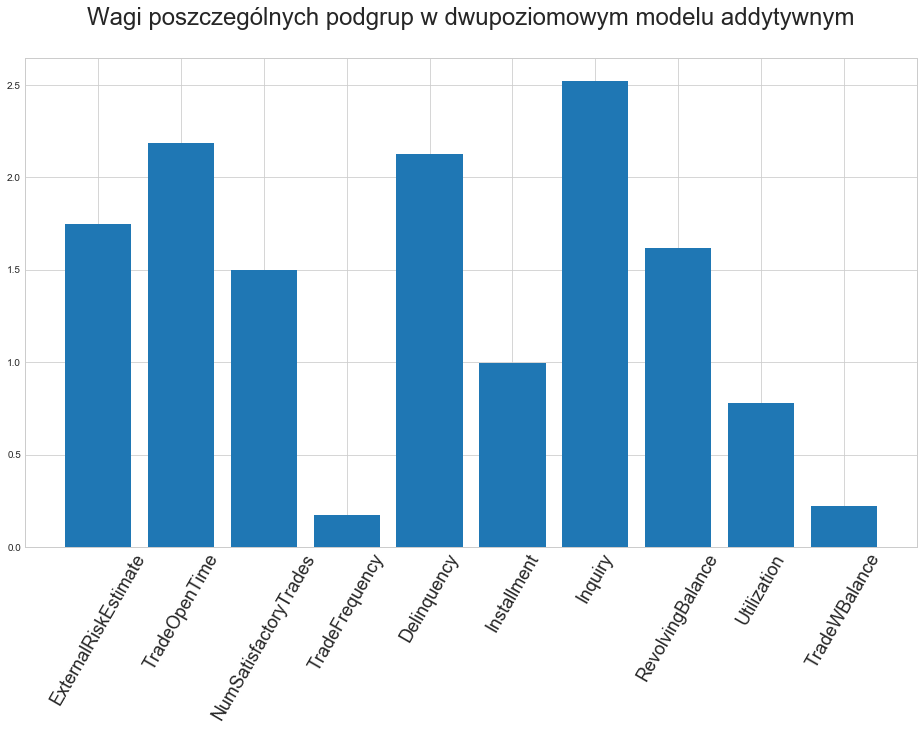

In [55]:
plt.figure(figsize=(16,9))
plt.bar(submodel_dictionary.keys(),model.coef_[0])
plt.title('Wagi poszczególnych podgrup w dwupoziomowym modelu addytywnym\n', size=24)
plt.xticks(size = 18, rotation=60)
plt.show()